In [2]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
%matplotlib inline

In [3]:
fpath = 'facebook_data_Forbes_post_sentiment.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,Text,Likes,Shares,PositiveScore,NegativeScore,NeutralScore,SentimentScore,TokenQnt,PositiveScoreAvg,NegativeScoreAvg,NeutralScoreAvg,SentimentScoreAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound,Flair_Score
0,1,10159570280702509,2021-05-15 16:33:10,Demand for travel is sky-high but many top hot...,189,12,0.125,0.250,17.625,-0.125,18,0.006944,0.013889,0.979167,-0.006944,0.052,0.029,0.919,0.2382,0.9150
1,2,10159573298827509,2021-05-16 19:30:09,"Ether prices recently surpassed $4,000, hittin...",4,3,1.625,0.750,12.625,0.875,15,0.108333,0.050000,0.841667,0.058333,0.229,0.000,0.771,0.7744,-0.9290
2,3,10159573296662509,2021-05-16 19:30:02,Clubhouse has launched to 2 billion Android us...,2,0,1.125,0.125,5.750,1.000,7,0.160714,0.017857,0.821429,0.142857,0.186,0.000,0.814,0.5187,-0.9471
3,4,10159573166042509,2021-05-16 18:35:31,"""We now live in a country where members' votes...",57,13,0.750,1.000,11.250,-0.250,13,0.057692,0.076923,0.865385,-0.019231,0.000,0.294,0.706,-0.8779,-0.9990
4,5,10159573151372509,2021-05-16 18:30:33,Both the Fed and the Treasury have dismissed s...,17,3,0.750,0.125,11.125,0.625,12,0.062500,0.010417,0.927083,0.052083,0.104,0.040,0.856,0.2748,-0.9935


In [4]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

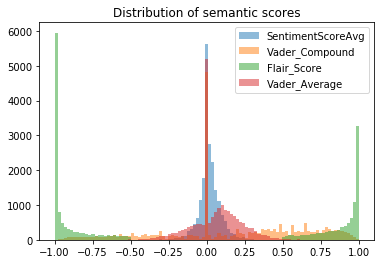

In [5]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['SentimentScoreAvg'], bins, alpha=0.5, label='SentimentScoreAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Flair_Score'], bins, alpha=0.5, label='Flair_Score')
pyplot.hist(post_data['Vader_Average'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

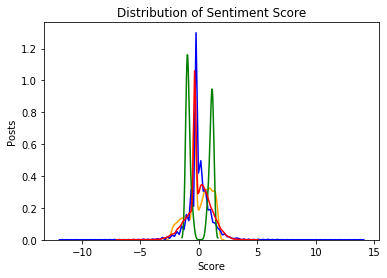

In [6]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['SentimentScoreAvg'] - post_data['SentimentScoreAvg'].mean())/post_data['SentimentScoreAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Flair_Score'] - post_data['Flair_Score'].mean())/post_data['Flair_Score'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [7]:
post_data[['SentimentScoreAvg','Vader_Compound','Flair_Score','Vader_Average']].describe()

,SentimentScoreAvg,Vader_Compound,Flair_Score,Vader_Average
count,20395.000000,20395.000000,20395.000000,20395.000000
mean,0.016608,0.178163,-0.078454,0.054961
std,0.071051,0.468883,0.906425,0.156805
min,-0.812500,-0.984700,-1.000000,-1.000000
25%,-0.008929,0.000000,-0.990100,0.000000
50%,0.005952,0.128000,-0.620900,0.027000
75%,0.048077,0.571900,0.935650,0.152000
max,1.000000,0.989500,1.000000,0.800000


In [8]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [9]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [11]:
DailyData = post_data.groupby('DateDay').agg({'SentimentScore': 'sum'
                                                         ,'TokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'Flair_Score':'mean'})

In [12]:
DailyData['SentimentScoreAdj'] = DailyData['SentimentScore']/DailyData['TokenQnt']
Monthly_Data['SentimentScoreAdj'] = Monthly_Data['SentimentScore']/Monthly_Data['TokenQnt']


In [13]:
DailyData.head()

,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
DateDay,,,,,,
2009-06-12,-0.250,1,0.00000,0.0000,-0.99560,-0.2500
2009-06-13,0.250,2,0.13660,0.0285,-0.89775,0.1250
2009-06-14,0.500,1,0.20230,0.1410,0.99750,0.5000
2009-06-15,-0.250,2,0.46710,0.1560,0.77405,-0.1250
2009-06-16,-0.875,2,-0.02625,-0.0290,-0.75855,-0.4375


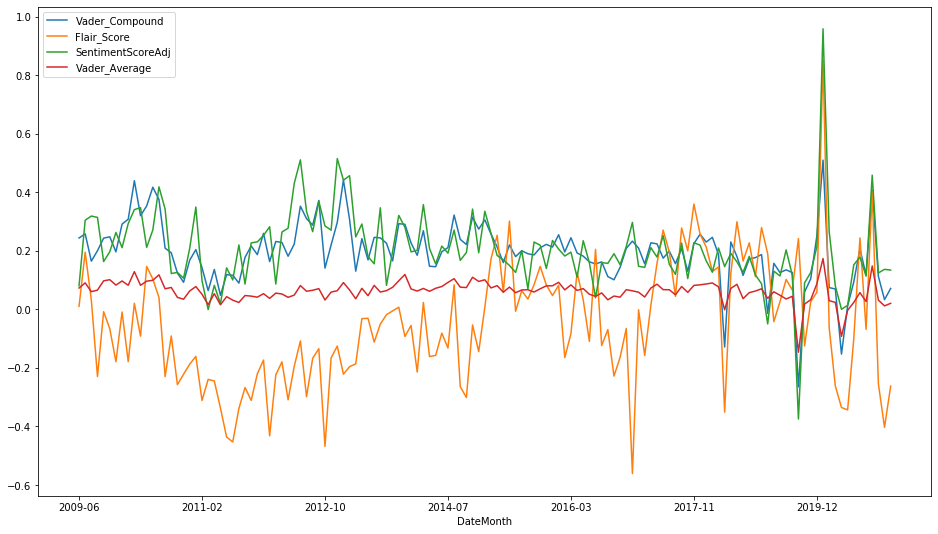

In [14]:
Monthly_Data[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']].plot(legend=True, figsize=(16,9))

In [18]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Flair_Score'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                -5.961782e+00
p-value                        2.030981e-07
#Lags Used                     2.800000e+01
Number of Observations Used    3.278000e+03
Critical Value (1%)           -3.432346e+00
Critical Value (5%)           -2.862422e+00
Critical Value (10%)          -2.567240e+00
dtype: float64


## Download S&P from Yahoo

In [23]:
SnP_daily = web.get_data_yahoo('^GSPC','09/01/2009','03/01/2021',interval='d')
SnP_monthly = web.get_data_yahoo('^GSPC','09/01/2009','03/01/2021',interval='m')

In [24]:
SnP_monthly

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2009-09-01,1080.150024,991.969971,1019.520020,1057.079956,112295490000,1057.079956
2009-10-01,1101.359985,1019.950012,1054.910034,1036.189941,113410990000,1036.189941
2009-11-01,1113.689941,1029.380005,1036.180054,1095.630005,84981530000,1095.630005
2009-12-01,1130.380005,1085.890015,1098.890015,1115.099976,89515330000,1115.099976
2010-01-01,1150.449951,1071.589966,1116.560059,1073.869995,90947580000,1073.869995
...,...,...,...,...,...,...
2020-11-01,3645.989990,3279.739990,3296.199951,3621.629883,100977880000,3621.629883
2020-12-01,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068
2021-01-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990


In [25]:
SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [26]:
SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

In [27]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [28]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [29]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [30]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [31]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,SentimentScore,TokenQnt,Vader_Compound,Vader_Average,Flair_Score,SentimentScoreAdj
2009-09,1080.150024,991.969971,1019.520020,1057.079956,112295490000,1057.079956,NaN,13.500000,43,0.200014,0.065605,-0.229670,0.313953
2009-10,1101.359985,1019.950012,1054.910034,1036.189941,113410990000,1036.189941,-0.019960,7.500000,46,0.243035,0.097109,-0.008198,0.163043
2009-11,1113.689941,1029.380005,1036.180054,1095.630005,84981530000,1095.630005,0.055779,6.875000,35,0.247657,0.101086,-0.066463,0.196429
2009-12,1130.380005,1085.890015,1098.890015,1115.099976,89515330000,1115.099976,0.017615,10.500000,40,0.196193,0.082625,-0.179110,0.262500
2010-01,1150.449951,1071.589966,1116.560059,1073.869995,90947580000,1073.869995,-0.037675,12.000000,57,0.291047,0.096684,-0.009284,0.210526
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09,3588.110107,3209.449951,3507.439941,3363.000000,92084120000,3363.000000,-0.040018,62.888000,414,0.093404,0.023449,-0.100889,0.151903
2020-11,3645.989990,3279.739990,3296.199951,3621.629883,100977880000,3621.629883,0.102146,9.625000,54,0.206556,0.056981,0.243707,0.178241
2020-12,3760.199951,3633.399902,3645.870117,3756.070068,96056410000,3756.070068,0.036449,46.500000,411,0.116962,0.026304,-0.068482,0.113139
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,2.750000,6,0.407283,0.148000,0.403667,0.458333


In [40]:
gc_res = grangercausalitytests(Granger_data_daily[["Vader_Compound","LogReturn"]].dropna(),11)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8231  , p=0.3644  , df_denom=2278, df_num=1
ssr based chi2 test:   chi2=0.8242  , p=0.3640  , df=1
likelihood ratio test: chi2=0.8241  , p=0.3640  , df=1
parameter F test:         F=0.8231  , p=0.3644  , df_denom=2278, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3406  , p=0.2619  , df_denom=2275, df_num=2
ssr based chi2 test:   chi2=2.6871  , p=0.2609  , df=2
likelihood ratio test: chi2=2.6855  , p=0.2611  , df=2
parameter F test:         F=1.3406  , p=0.2619  , df_denom=2275, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9465  , p=0.4172  , df_denom=2272, df_num=3
ssr based chi2 test:   chi2=2.8483  , p=0.4156  , df=3
likelihood ratio test: chi2=2.8465  , p=0.4159  , df=3
parameter F test:         F=0.9465  , p=0.4172  , df_denom=2272, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.6828  , p=0.

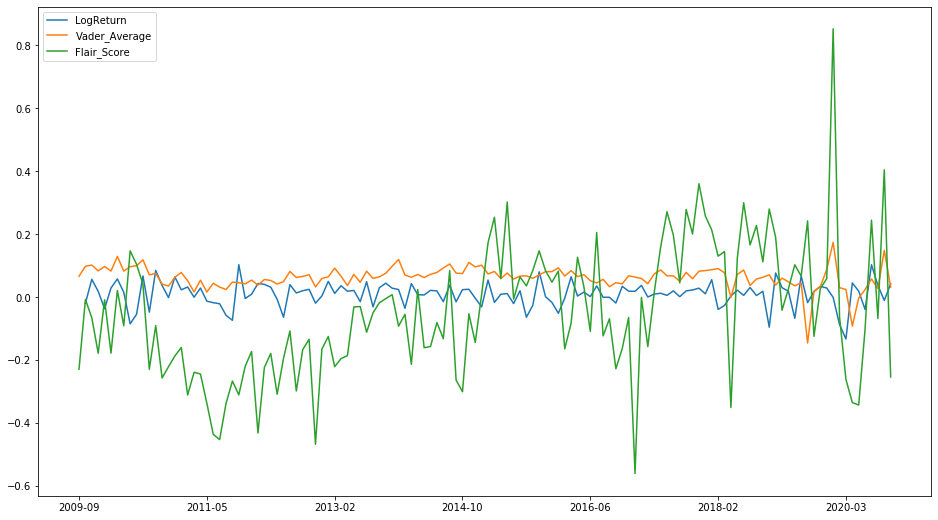

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Flair_Score']].plot(legend=True, figsize=(16,9))

In [41]:
corr = Granger_data_daily[['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average', 'LogReturn']].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Flair_Score,SentimentScoreAdj,Vader_Average,LogReturn
Vader_Compound,1.000000,0.322573,0.449686,0.890435,0.008323
Flair_Score,0.322573,1.000000,0.139165,0.376145,0.014261
SentimentScoreAdj,0.449686,0.139165,1.000000,0.372811,0.002854
Vader_Average,0.890435,0.376145,0.372811,1.000000,0.013803
LogReturn,0.008323,0.014261,0.002854,0.013803,1.000000


In [42]:
pvals = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif

,p-value
Vader_Compound,0.695046
Flair_Score,0.503484
SentimentScoreAdj,0.893773
Vader_Average,0.513103


In [43]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.440340
Flair_Score,0.898806
SentimentScoreAdj,0.677175
Vader_Average,0.448418
